## Experiments template for networks of different sizes, 1 sample from each size of network, multiple runs per sample

In [7]:
import os


dir = "networks"
os.makedirs(os.path.dirname(dir+"/"), exist_ok=True)


def make_dir(dir):
    if not os.path.exists(dir):
        os.mkdir(dir)

### Generate networks

First fixed Powerlaw networks with m = 1, and p = 0.2.\
Variable number of nodes.

In [9]:
m = 1
p = 0.2

In [10]:
dir = f"networks/powerlaw_m={m}_p={p}"
os.makedirs(os.path.dirname(dir+"/"), exist_ok=True)

In [4]:
import numpy as np


MIN_NODES = 10
MAX_NODES = 100

num_nodes = np.linspace(MIN_NODES, MAX_NODES, MAX_NODES//MIN_NODES)
num_nodes

array([ 10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.])

In [105]:
import numpy as np
import networkx as nx


try:
    Graphs = np.load(f"{dir}/graphs.npy", allow_pickle=True)
except:
    Graphs = np.empty(shape=(len(num_nodes),), dtype=object)
    for i, n in enumerate(num_nodes):
        Graphs[i] = nx.powerlaw_cluster_graph(n=n, m=m, p=p)
    np.save(f"{dir}/graphs.npy", Graphs)

In [11]:
# output folder
dir =dir+"/output"
os.makedirs(os.path.dirname(dir+"/"), exist_ok=True)

#### Hierarchical approach with Gurobi first

In [7]:
solver = "gurobi"
make_dir(f"{dir}/{solver}")

In [1]:
from Qommunity.samplers.hierarchical.gurobi_sampler import GurobiSampler
from Qommunity.searchers.hierarchical_community_searcher.hierarchical_community_searcher import HierarchicalCommunitySearcher

In [ ]:
from tqdm import tqdm


N_RUNS = 100


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    gurobi = GurobiSampler(G, suppress_output=True)
    hierch_searcher = HierarchicalCommunitySearcher(gurobi)  
    for r in range(N_RUNS):
        comms_res = hierch_searcher.hierarchical_community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/{solver}-mods_final", mods)
np.save(f"{dir}/{solver}/{solver}-comms_final", comms)

#### Now Advantage

In [11]:
solver = "adv"
make_dir(f"{dir}/{solver}")

In [2]:
from Qommunity.samplers.hierarchical.advantage_sampler import AdvantageSampler
from Qommunity.searchers.hierarchical_community_searcher.hierarchical_community_searcher import HierarchicalCommunitySearcher

In [ ]:
from tqdm import tqdm


N_RUNS = 50


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    advantage = AdvantageSampler(G, num_reads=100)
    hierch_searcher = HierarchicalCommunitySearcher(advantage)
    
    current_net_size = int(num_nodes[i])
    for r in range(N_RUNS):
        comms_res = hierch_searcher.hierarchical_community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

        # For bigger graphs computations take time, so better save it up
        # even for each run
        try:
            np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
            np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)
        except Exception as e:
            print(f"iter {i} run {r} npy saving failed:\n{e}")

    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/{solver}-mods_final", mods)
np.save(f"{dir}/{solver}/{solver}-comms_final", comms)

### Now Leiden

In [14]:
solver = "leiden"
make_dir(f"{dir}/{solver}")

In [15]:
from Qommunity.samplers.regular.leiden_sampler import LeidenSampler
from Qommunity.searchers.community_searcher.community_searcher import CommunitySearcher

In [16]:
from tqdm import tqdm


N_RUNS = 100


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    leiden = LeidenSampler(G)
    searcher = CommunitySearcher(leiden)
    
    for r in range(N_RUNS):
        comms_res = searcher.community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/{solver}-mods_final", mods)
np.save(f"{dir}/{solver}/{solver}-comms_final", comms)

10it [00:00, 19.89it/s]


#### Louvain

In [17]:
solver = "louvain"
make_dir(f"{dir}/{solver}")

In [18]:
from Qommunity.samplers.regular.louvain_sampler import LouvainSampler
from Qommunity.searchers.community_searcher import CommunitySearcher

In [19]:
from tqdm import tqdm


N_RUNS = 100


mods = np.zeros((num_nodes.shape[0], N_RUNS))
comms = np.empty((num_nodes.shape[0], N_RUNS), dtype=object)

mods_graph_N = np.zeros((N_RUNS))
comms_graph_N = np.empty((N_RUNS), dtype=object)
for i, G in tqdm(enumerate(Graphs)):
    louvain = LouvainSampler(G)
    searcher = CommunitySearcher(louvain)
    
    for r in range(N_RUNS):
        comms_res = searcher.community_search()
        mod_score = nx.community.modularity(G, comms_res)
        mods_graph_N[r] = mod_score
        comms_graph_N[r] = comms_res

    current_net_size = int(num_nodes[i])
    mods[i] = mods_graph_N
    comms[i] = comms_graph_N
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}", mods_graph_N)
    np.save(f"{dir}/{solver}/{solver}-network_size_{current_net_size}_comms", comms_graph_N)

np.save(f"{dir}/{solver}/{solver}-mods_final", mods)
np.save(f"{dir}/{solver}/{solver}-comms_final", comms)

10it [00:02,  4.54it/s]


### Let's plot the modularity results

In [15]:
mods_gurobi = np.load(f"{dir}/gurobi/gurobi-mods_final.npy")
mods_leiden = np.load(f"{dir}/leiden/leiden-mods_final.npy")
mods_louvain = np.load(f"{dir}/louvain/louvain-mods_final.npy")
# mods_adv = np.load(f"{dir}/adv/adv-mods_final.npy")

In [16]:
mods_adv = np.array([np.load(f"{dir}/adv/adv-network_size_{n}.npy") for n in range(10, 90, 10)])

In [17]:
print("\t\tMaxes\n")
print("\tadv\tlei\tgur\tlou")
digits = 8
for madv, mlei, mgur, mlou in zip(mods_adv.max(axis=-1), mods_leiden.max(axis=-1), mods_gurobi.max(axis=-1), mods_louvain.max(axis=-1)):
    madv = round(madv, digits)
    mlei = round(mlei, digits)
    mgur = round(mgur, digits)
    mlou = round(mlou, digits)
    print(madv, mlei, mgur, mlou, "\t\t", madv == mlei == mgur == mlou)
    print()


		Maxes

	adv	lei	gur	lou
0.38271605 0.38271605 0.38271605 0.38271605 		 True

0.55124654 0.55124654 0.55124654 0.55124654 		 True

0.58858502 0.58858502 0.58858502 0.58858502 		 True

0.67784352 0.67784352 0.67784352 0.67784352 		 True

0.65368596 0.65368596 0.65368596 0.65368596 		 True

0.70051709 0.70051709 0.69750072 0.70051709 		 False

0.76307498 0.76307498 0.76307498 0.76307498 		 True

0.76307498 0.64500881 0.64500881 0.64500881 		 False



In [18]:
print("\t\tMeans\n")
print("\tadv\tlei\tgur\tlou")
digits = 8
for madv, mlei, mgur, mlou in zip(mods_adv.mean(axis=-1), mods_leiden.mean(axis=-1), mods_gurobi.mean(axis=-1), mods_louvain.mean(axis=-1)):
    madv = round(madv, digits)
    mlei = round(mlei, digits)
    mgur = round(mgur, digits)
    mlou = round(mlou, digits)
    print(madv, mlei, mgur, mlou, "\t\t", madv == mlei == mgur == mlou)
    print()


		Means

	adv	lei	gur	lou
0.38271605 0.38271605 0.38271605 0.38271605 		 True

0.55124654 0.55124654 0.55124654 0.55124654 		 True

0.58858502 0.58858502 0.58858502 0.58858502 		 True

0.67784352 0.67784352 0.67784352 0.67784352 		 True

0.65368596 0.65368596 0.65368596 0.65269471 		 False

0.69038495 0.70051709 0.69750072 0.70036627 		 False

0.76042638 0.76307498 0.76307498 0.76307498 		 False

0.66912047 0.64500881 0.64500881 0.64500881 		 False



(5.0, 110.0)

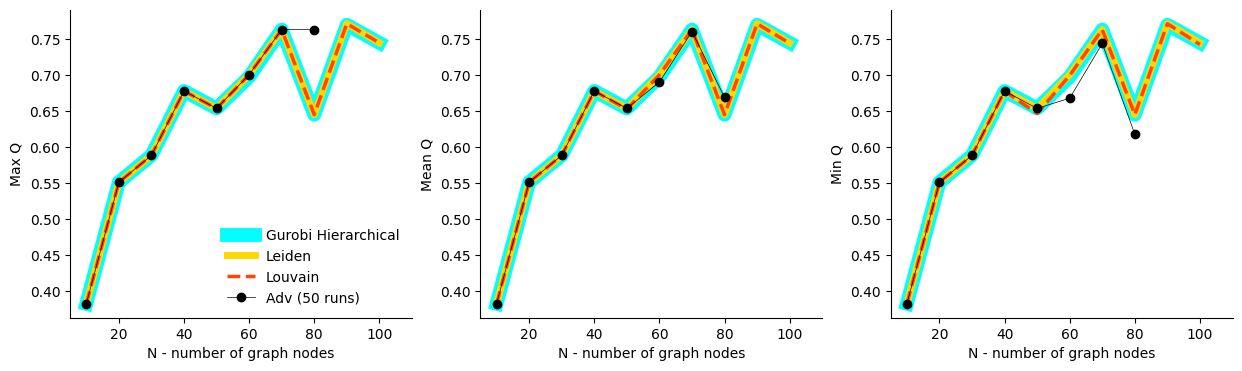

In [99]:
from matplotlib import pyplot as plt

id = 8
num_nodes_up_to_80 = num_nodes[:id]


fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(num_nodes, mods_gurobi.max(axis=-1), '-', label="Gurobi Hierarchical", linewidth=10, color='cyan')
ax[0].plot(num_nodes, mods_leiden.max(axis=-1), '-', label="Leiden", linewidth=5, color='gold')
ax[0].plot(num_nodes, mods_louvain.max(axis=-1), '--', label="Louvain", linewidth=2.5, color='orangered')
ax[0].plot(num_nodes_up_to_80, mods_adv.max(axis=-1), '-o', label="Adv (50 runs)", linewidth=0.5, color='black')
ax[0].legend(frameon=False)
ax[0].spines[["top","right"]].set_visible(False)
ax[0].set_xlabel("N - number of graph nodes");
ax[0].set_ylabel("Max Q");
ax[0].set_xlim([-5+num_nodes[0],num_nodes[-1]+10])

ax[1].plot(num_nodes, mods_gurobi.mean(axis=-1), '-', linewidth=10, color='cyan')
ax[1].plot(num_nodes, mods_leiden.mean(axis=-1), '-', linewidth=5, color='gold')
ax[1].plot(num_nodes, mods_louvain.mean(axis=-1), '--', linewidth=2.5, color='orangered')
ax[1].plot(num_nodes_up_to_80, mods_adv.mean(axis=-1), '-o', linewidth=0.5, color='black')
ax[1].spines[["top","right"]].set_visible(False)
ax[1].set_xlabel("N - number of graph nodes");
ax[1].set_ylabel("Mean Q");
ax[1].set_xlim([-5+num_nodes[0],num_nodes[-1]+10])

ax[2].plot(num_nodes, mods_gurobi.min(axis=-1), '-', linewidth=10, color='cyan')
ax[2].plot(num_nodes, mods_leiden.min(axis=-1), '-', linewidth=5, color='gold')
ax[2].plot(num_nodes, mods_louvain.min(axis=-1), '--', linewidth=2.5, color='orangered')
ax[2].plot(num_nodes_up_to_80, mods_adv.min(axis=-1), '-o', linewidth=0.5, color='black')
ax[2].spines[["top","right"]].set_visible(False)
ax[2].set_xlabel("N - number of graph nodes");
ax[2].set_ylabel("Min Q");
ax[2].set_xlim([-5+num_nodes[0],num_nodes[-1]+10])

(0.6128, 0.7681)

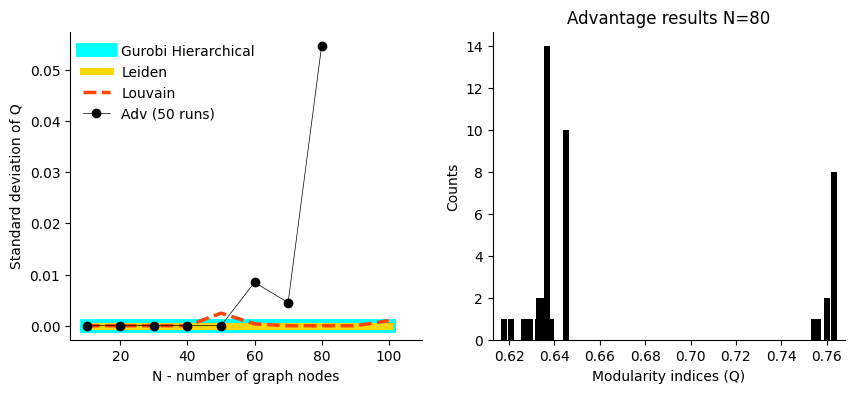

In [134]:
fig, (ax,ax1) = plt.subplots(1,2,figsize=(10,4))
ax.plot(num_nodes, mods_gurobi.std(axis=-1), '-', label="Gurobi Hierarchical", linewidth=10, color='cyan')
ax.plot(num_nodes, mods_leiden.std(axis=-1), '-', label="Leiden", linewidth=5, color='gold')
ax.plot(num_nodes, mods_louvain.std(axis=-1), '--', label="Louvain", linewidth=2.5, color='orangered')
ax.plot(num_nodes_up_to_80, mods_adv.std(axis=-1), '-o', label="Adv (50 runs)", linewidth=0.5, color='black')
ax.legend(frameon=False)
ax.spines[["top","right"]].set_visible(False)
ax.set_xlabel("N - number of graph nodes");
ax.set_ylabel("Standard deviation of Q");
ax.set_xlim([-5+num_nodes[0],num_nodes[-1]+10])

mods, freqs = np.unique(mods_adv[-1].round(decimals=4), return_counts=True)
ax1.bar(mods, freqs, width=0.0025, color='black')
ax1.spines[["top","right"]].set_visible(False)
ax1.set_xlabel("Modularity indices (Q)");
ax1.set_ylabel("Counts");
ax1.set_title("Advantage results N=80")
ax1.set_xlim([mods[0]-0.005,mods[-1]+0.005])

## Possible mistakes are unmasked below

In [174]:
adv_comms_n80 = np.load(f"{dir}/adv/adv-network_size_{80}_comms.npy", allow_pickle=True)
adv_comms_n70 = np.load(f"{dir}/adv/adv-network_size_{70}_comms.npy", allow_pickle=True)

In [170]:
len(adv_comms_n80)

50

In [171]:
np.argmax(mods_adv[-1])

38

In [172]:
mods_adv[-1,38]

0.763074984247007

What is going on here? Where are the nodes from 70 to 79? 

In [185]:
adv_comms_n80[40]

[[4, 11, 19, 27, 30, 49],
 [15, 18, 40, 51, 56, 59, 66],
 [20, 26, 31, 38, 47, 60, 65],
 [0, 5, 6, 9, 17, 23, 28, 29, 46, 61],
 [2, 7, 8, 14, 25, 43, 50, 67],
 [1, 3, 13, 16, 22, 39, 48, 55, 64, 68],
 [10, 32, 35, 42, 69],
 [12, 33, 36, 37, 44, 45, 53, 58, 62, 63],
 [21, 24, 34, 41, 52, 54, 57]]

Moreover...

In [186]:
adv_comms_n80[38]

[[15, 18, 40, 51, 56, 59, 66],
 [10, 32, 35, 42, 69],
 [21, 24, 34, 41, 52, 54, 57],
 [20, 26, 31, 38, 47, 60, 65],
 [0, 5, 6, 9, 17, 23, 28, 29, 46, 61],
 [12, 33, 36, 37, 44, 45, 53, 58, 62, 63],
 [2, 7, 8, 14, 25, 43, 50, 67],
 [1, 3, 13, 16, 22, 39, 48, 55, 64, 68],
 [4, 11, 19, 27, 30, 49]]

In [183]:
adv_comms_n70[38]

[[15, 18, 40, 51, 56, 59, 66],
 [10, 32, 35, 42, 69],
 [21, 24, 34, 41, 52, 54, 57],
 [20, 26, 31, 38, 47, 60, 65],
 [0, 5, 6, 9, 17, 23, 28, 29, 46, 61],
 [12, 33, 36, 37, 44, 45, 53, 58, 62, 63],
 [2, 7, 8, 14, 25, 43, 50, 67],
 [1, 3, 13, 16, 22, 39, 48, 55, 64, 68],
 [4, 11, 19, 27, 30, 49]]

In [168]:
nx.community.modularity(Graphs[7], adv_comms_n80[38])

NotAPartition: [[15, 18, 40, 51, 56, 59, 66], [10, 32, 35, 42, 69], [21, 24, 34, 41, 52, 54, 57], [20, 26, 31, 38, 47, 60, 65], [0, 5, 6, 9, 17, 23, 28, 29, 46, 61], [12, 33, 36, 37, 44, 45, 53, 58, 62, 63], [2, 7, 8, 14, 25, 43, 50, 67], [1, 3, 13, 16, 22, 39, 48, 55, 64, 68], [4, 11, 19, 27, 30, 49]] is not a valid partition of the graph Graph with 80 nodes and 79 edges

In [161]:
list(Graphs[7].nodes())[-1]

79

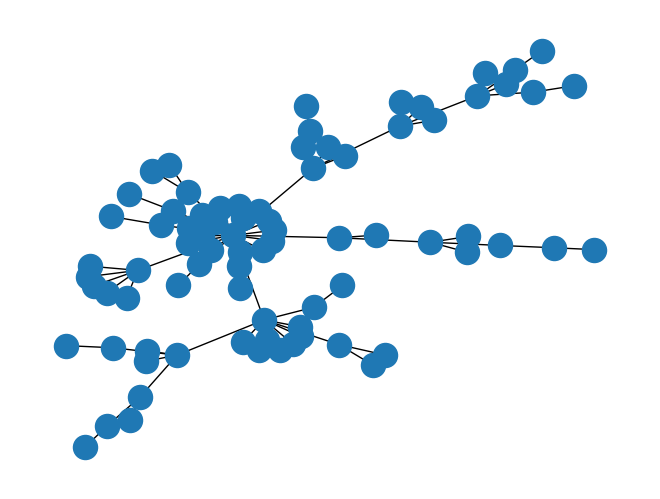

In [163]:
nx.draw(Graphs[7])